# Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
train_data = pd.read_csv('train_data.txt', sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head(3)
df = train_data

In [ ]:
train_data.head(100)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,listening conversation doctor parent 10 year o...
2,Cupid (1997),thriller,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,bus empty student field trip museum natural hi...
4,The Secret Sin (1915),drama,help unemployed father make end meet edith twi...
5,The Unrecovered (2007),drama,film title refers un recovered body ground zer...
...,...,...,...
96,[Rec] 2: En un mundo de infectados (2010),documentary,feature documentary follows various different ...
97,Agni kai atimasmeni (1962),drama,indicated title obvious melodrama beautiful ri...
98,Dr. Del (2016),drama,del canyon reluctantly return small hometown r...
99,Henry & Verlin (1996),drama,verlin 9 year old talk even seem hear henry ch...


In [ ]:
df = train_data

# EDA

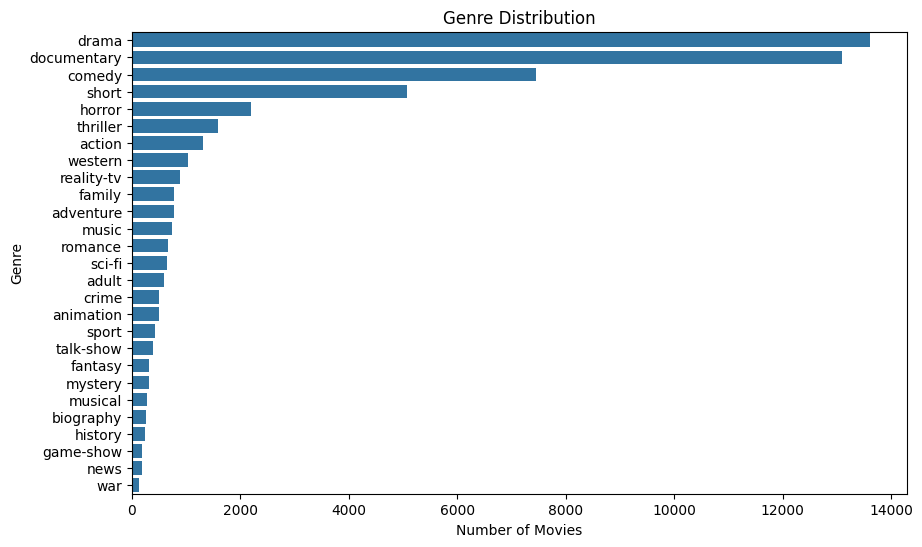

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['Genre'].str.strip(), order = df['Genre'].str.strip().value_counts().index)
plt.title('Genre Distribution')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

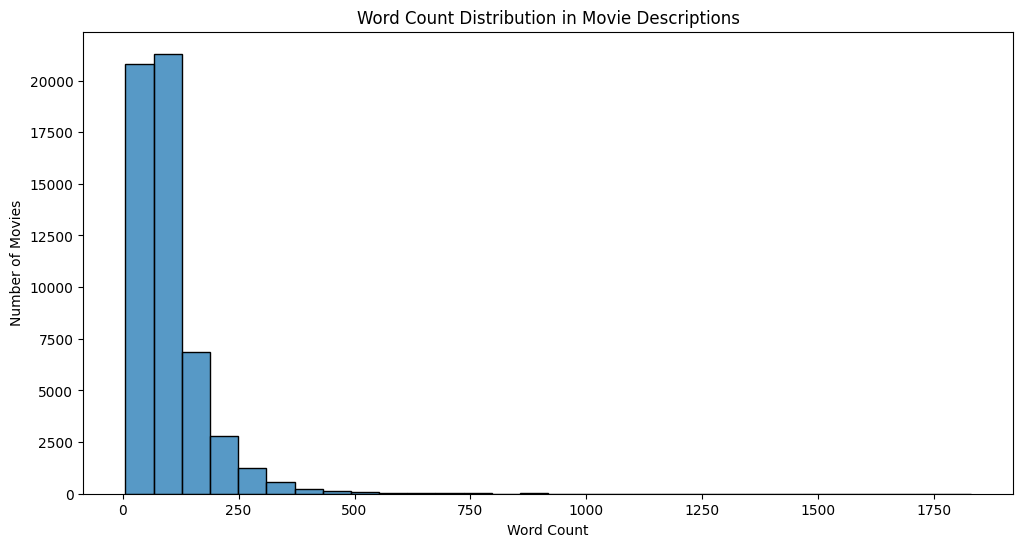

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Description'].str.split().apply(len), bins=30, kde=False)
plt.title('Word Count Distribution in Movie Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Number of Movies')
plt.show()

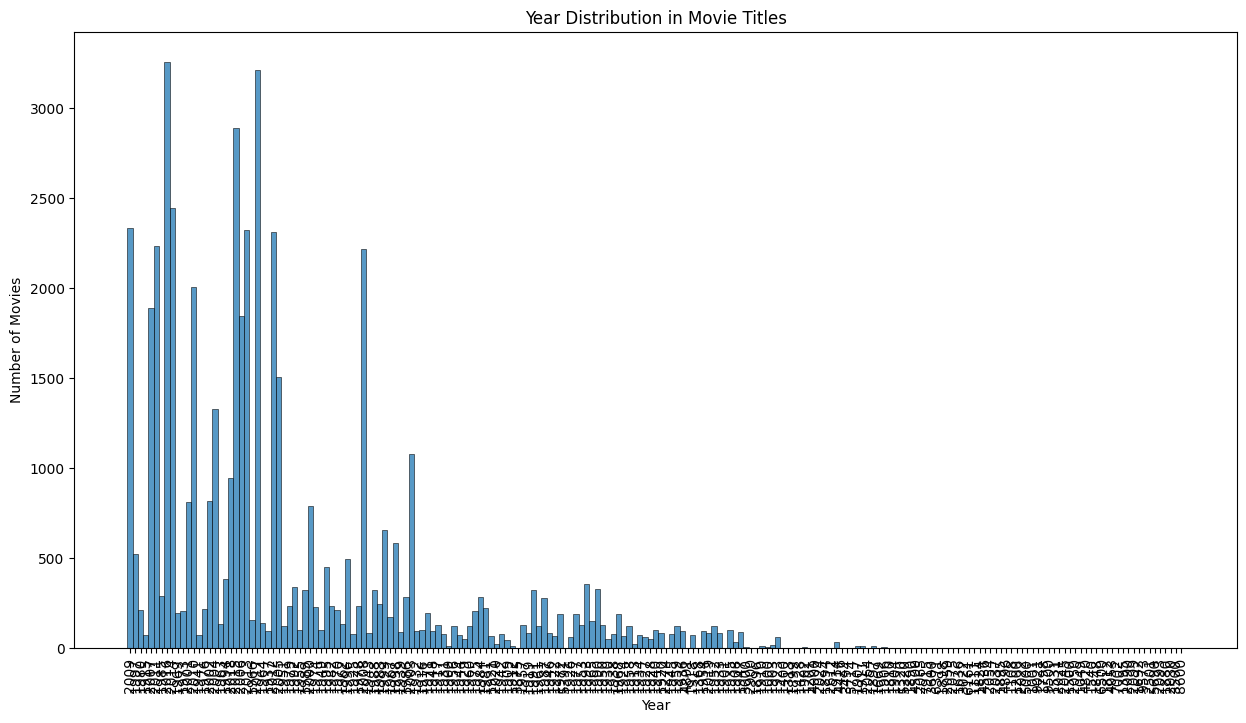

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(df['Title'].str.extract('(\d{4})')[0].dropna(), bins=30, kde=False)
plt.title('Year Distribution in Movie Titles')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

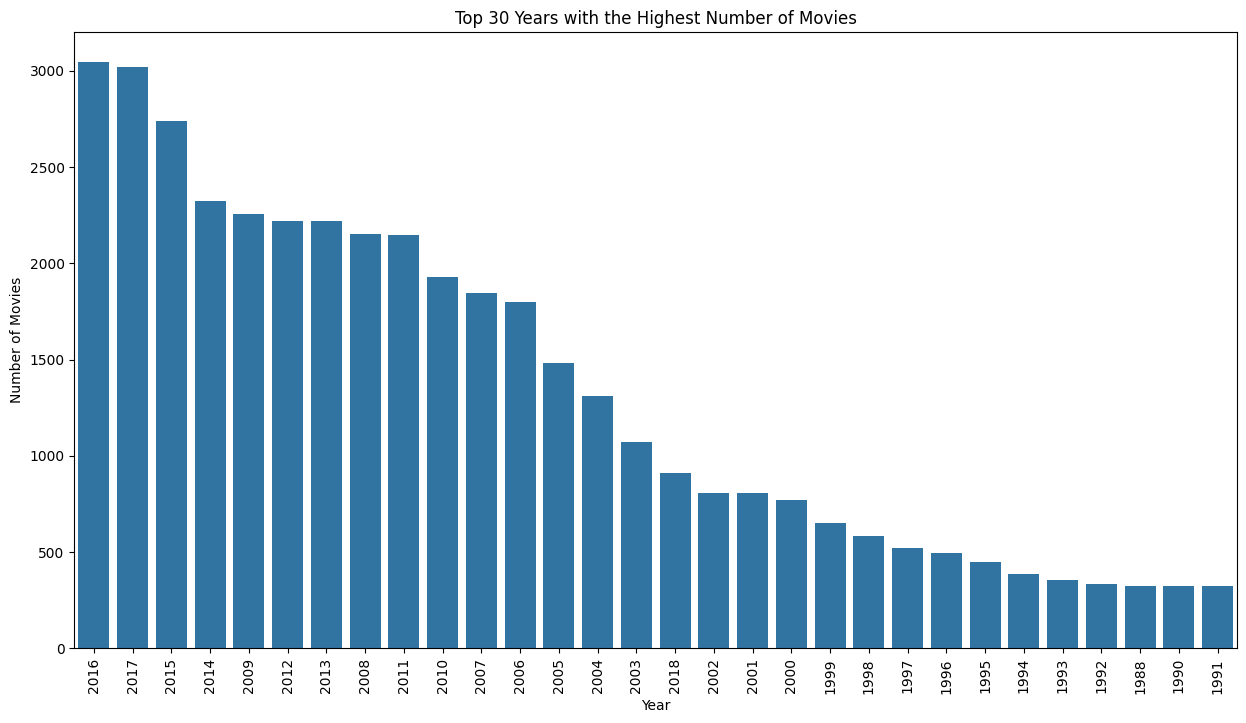

In [ ]:
year_occurrences = df['Title'].str.extract(r'\((\d{4})\)')[0].value_counts().head(30)

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(x=year_occurrences.index, y=year_occurrences.values)
plt.title('Top 30 Years with the Highest Number of Movies')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

It can be seen that the data is highly imbalanced.

1. The Genre distribution is highly imbalanced with 'Drama', 'Documentary' and 'Comedy' taking up more than 50% of the dataset. This needs to be addressed to develop a viable solution.

2. The word count distribution is skewed. Around 60000 descriptions are under 250 words. This is acceptable, however the model may not perform well on longer texts.

3. The year distribution may or may not have an effect.

# Preprocessing

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[' + string.punctuation + ']', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back to string
    text = ' '.join(tokens)
    return text

In [ ]:
# Applying preprocessing to the description column
df['Description'] = df['Description'].apply(preprocess_text)

In [ ]:
df['Description'].head()[1]

'listening conversation doctor parent 10 year old oscar learns nobody courage tell week live furious refuse speak anyone except straight talking rose lady pink meet hospital stair christmas approach rose us fantastical experience professional wrestler imagination wit charm allow oscar live life love full company friend pop corn einstein bacon childhood sweetheart peggy blue'

In [ ]:
# Feature Extraction: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Description'])

In [ ]:
X_tfidf.shape

(54214, 1000)

# Naive Bayes Benchmarking

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['Genre'], test_size=0.2, random_state=42)

In [ ]:
# Creating and training the Naive Bayes model
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

# Making predictions on the test set
nb_predictions = naive_bayes_classifier.predict(X_test)

# Evaluating the model
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_classification_report = classification_report(y_test, nb_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(nb_accuracy)

0.48667342986258416


In [ ]:
print(nb_classification_report)

               precision    recall  f1-score   support

      action        0.42      0.03      0.06       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.49      0.30      0.37      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.86      0.67      2659
       drama        0.42      0.83      0.56      2697
      family        1.00      0.02      0.04       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.10      0.18        40
     history        0.00      0.00      0.00        45
      horror        0.67      0.19      0.30       431
       music        0.65      0.22      0.33       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


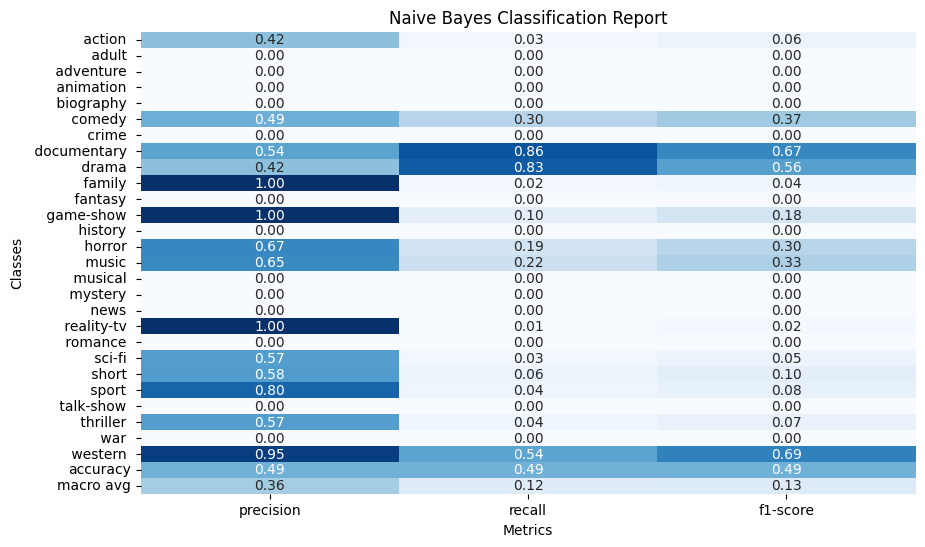

In [ ]:
from sklearn.metrics import classification_report

# Convert classification report string to dictionary
nb_classification_report_dict = classification_report(y_test, nb_predictions, output_dict=True)

# Convert dictionary to DataFrame
nb_classification_report_df = pd.DataFrame(nb_classification_report_dict).transpose()

# Plot classification report heatmap for Naive Bayes
plt.figure(figsize=(10, 6))
sns.heatmap(nb_classification_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Naive Bayes Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

# Logistic Regression

In [ ]:
# Creating and training the Logistic Regression model
logistic_regression_classifier = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_classifier.fit(X_train, y_train)

# Making predictions on the test set
lr_predictions = logistic_regression_classifier.predict(X_test)

# Evaluating the model
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_classification_report = classification_report(y_test, lr_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(lr_accuracy)

0.5525223646592271


In [ ]:
print(lr_classification_report)

               precision    recall  f1-score   support

      action        0.38      0.20      0.26       263
       adult        0.76      0.22      0.34       112
   adventure        0.30      0.10      0.15       139
   animation        0.33      0.05      0.08       104
   biography        0.00      0.00      0.00        61
      comedy        0.46      0.52      0.49      1443
       crime        0.30      0.06      0.09       107
 documentary        0.67      0.83      0.74      2659
       drama        0.52      0.74      0.61      2697
      family        0.37      0.11      0.17       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.87      0.33      0.47        40
     history        0.00      0.00      0.00        45
      horror        0.56      0.55      0.56       431
       music        0.57      0.52      0.55       144
     musical        0.38      0.06      0.10        50
     mystery        0.67      0.04      0.07        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


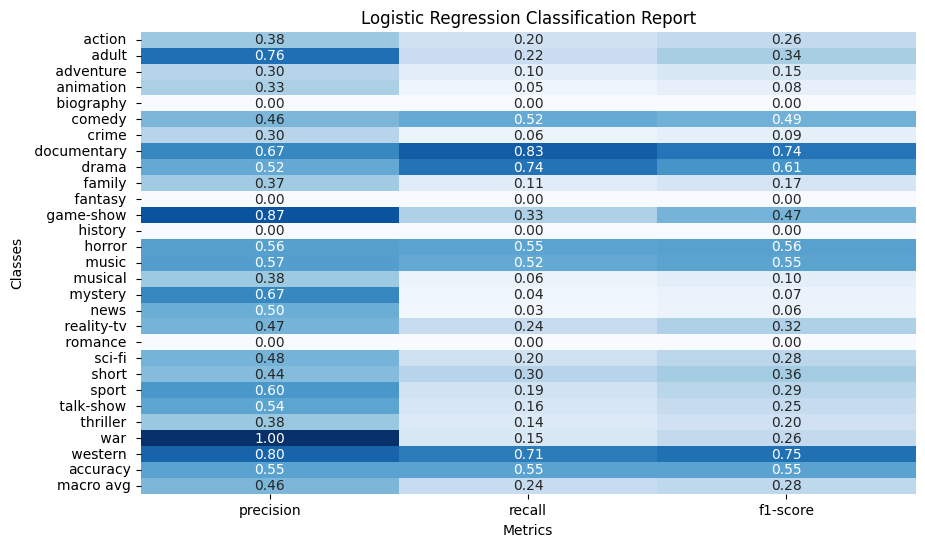

In [ ]:
# Generate classification report for Logistic Regression
lr_classification_report = classification_report(y_test, lr_predictions, output_dict=True)

# Convert classification report to DataFrame
lr_classification_report_df = pd.DataFrame(lr_classification_report).transpose()

# Plot classification report heatmap for Logistic Regression
plt.figure(figsize=(10, 6))
sns.heatmap(lr_classification_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Logistic Regression Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

# Random Forrest

In [ ]:
# To handle class imbalance, we can use class_weight='balanced'
random_forest_classifier = RandomForestClassifier(
    class_weight='balanced',
    n_jobs=-1,         # Use all available cores
    random_state=42
)

# Training the model
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# Making predictions on the test set
rf_predictions = random_forest_classifier.predict(X_test)

In [ ]:
# Evaluating the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(rf_accuracy)

0.4819699345199668


In [ ]:
print(rf_classification_report)

               precision    recall  f1-score   support

      action        0.18      0.01      0.01       263
       adult        0.43      0.18      0.25       112
   adventure        0.27      0.02      0.04       139
   animation        0.31      0.04      0.07       104
   biography        0.00      0.00      0.00        61
      comedy        0.49      0.28      0.36      1443
       crime        0.20      0.01      0.02       107
 documentary        0.56      0.80      0.66      2659
       drama        0.42      0.81      0.55      2697
      family        0.80      0.03      0.05       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.85      0.42      0.57        40
     history        0.00      0.00      0.00        45
      horror        0.53      0.25      0.34       431
       music        0.51      0.47      0.49       144
     musical        0.11      0.02      0.03        50
     mystery        0.00      0.00      0.00        56
        n

In [ ]:
random_forest_params = random_forest_classifier.get_params()
random_forest_params


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


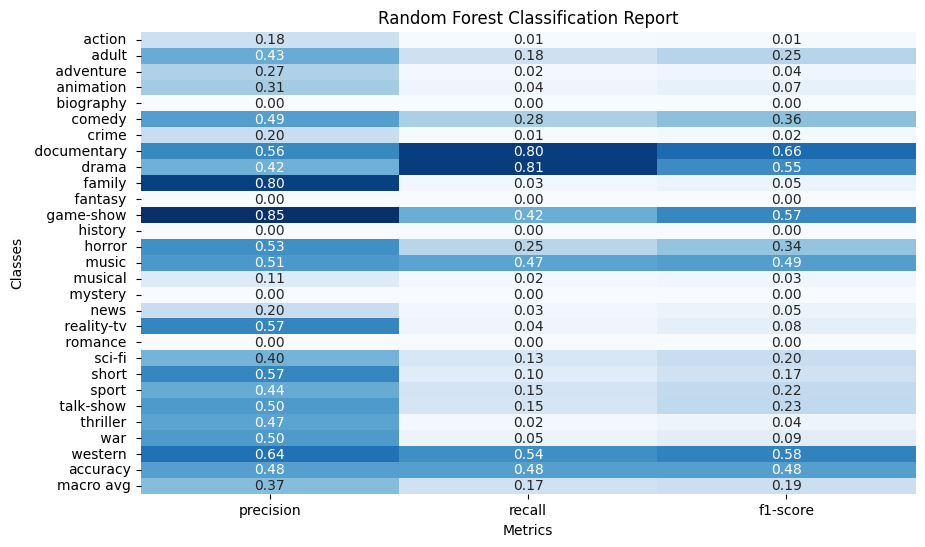

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report for Random Forest
rf_classification_report = classification_report(y_test, rf_predictions, output_dict=True)

# Convert classification report to DataFrame
rf_classification_report_df = pd.DataFrame(rf_classification_report).transpose()

# Plot classification report heatmap for Random Forest
plt.figure(figsize=(10, 6))
sns.heatmap(rf_classification_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Random Forest Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()


# Support Vector Machine

In [ ]:
from sklearn.linear_model import SGDClassifier

# Create an SGDClassifier with hinge loss (linear SVM)
svm_batch_classifier = SGDClassifier(loss='hinge', penalty='l2',  random_state=42)

# Train the SVM model in batches
batch_size = 1000
num_samples = X_train.shape[0]  # Get the number of samples
for i in range(0, num_samples, batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    svm_batch_classifier.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

# Make predictions on the test set
svm_batch_predictions = svm_batch_classifier.predict(X_test)

# Evaluate the model
svm_batch_accuracy = accuracy_score(y_test, svm_batch_predictions)
svm_batch_classification_report = classification_report(y_test, svm_batch_predictions)

In [ ]:
print(svm_batch_accuracy)

0.5178456146822835


In [ ]:
print(svm_batch_classification_report)

               precision    recall  f1-score   support

      action        0.19      0.08      0.12       263
       adult        0.36      0.18      0.24       112
   adventure        0.16      0.09      0.12       139
   animation        0.22      0.05      0.08       104
   biography        0.00      0.00      0.00        61
      comedy        0.45      0.41      0.43      1443
       crime        0.09      0.02      0.03       107
 documentary        0.64      0.84      0.73      2659
       drama        0.52      0.71      0.60      2697
      family        0.28      0.12      0.17       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.58      0.55      0.56        40
     history        0.00      0.00      0.00        45
      horror        0.39      0.61      0.47       431
       music        0.52      0.44      0.48       144
     musical        0.17      0.06      0.09        50
     mystery        0.00      0.00      0.00        56
        n

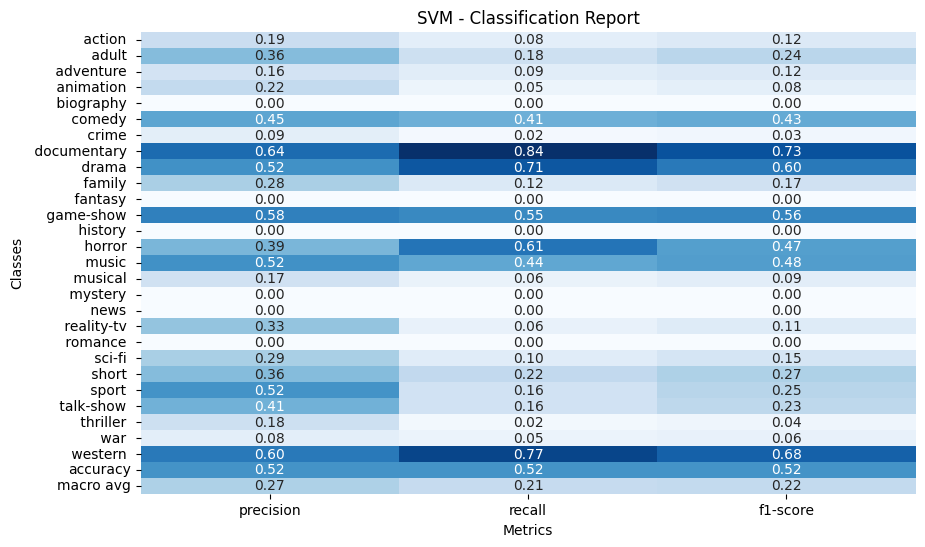

In [ ]:
# Generate a classification report
classification_report_str = classification_report(y_test, svm_batch_predictions, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_str).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(classification_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('SVM - Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid_linear_svc = {'C': [0.1, 1, 10]}

# Create SVM classifiers
svm_classifier_linear_svc = LinearSVC(class_weight='balanced', random_state=42)

# Perform grid search cross-validation
grid_search_linear_svc = GridSearchCV(svm_classifier_linear_svc, param_grid_linear_svc, cv=5, scoring='accuracy')

# Fit the models
grid_search_linear_svc.fit(X_train, y_train)

# Get the best parameters and scores
best_params_linear_svc = grid_search_linear_svc.best_params_
best_score_linear_svc = grid_search_linear_svc.best_score_

best_params_linear_svc, best_score_linear_svc


KeyboardInterrupt: 

In [ ]:
print(best_params_linear_svc)

In [ ]:
print(best_score_linear_svc)